# Autoencoder: Neural Network for Unsupervised Representation Learning

## 1. Introduction

An **autoencoder** is an unsupervised neural network architecture designed to learn efficient representations (encodings) of input data. The network learns to compress data into a lower-dimensional latent space and then reconstruct it, effectively learning the most salient features of the data distribution.

## 2. Mathematical Foundation

### 2.1 Architecture Overview

An autoencoder consists of two main components:

1. **Encoder** $f_\phi: \mathcal{X} \rightarrow \mathcal{Z}$ that maps input $\mathbf{x}$ to latent representation $\mathbf{z}$
2. **Decoder** $g_\theta: \mathcal{Z} \rightarrow \mathcal{X}$ that reconstructs $\hat{\mathbf{x}}$ from $\mathbf{z}$

### 2.2 Encoder Function

For a single hidden layer encoder:

$$\mathbf{z} = f_\phi(\mathbf{x}) = \sigma(\mathbf{W}_e \mathbf{x} + \mathbf{b}_e)$$

where:
- $\mathbf{W}_e \in \mathbb{R}^{d_z \times d_x}$ is the encoder weight matrix
- $\mathbf{b}_e \in \mathbb{R}^{d_z}$ is the encoder bias vector
- $\sigma(\cdot)$ is a nonlinear activation function
- $d_x$ is the input dimension, $d_z$ is the latent dimension

### 2.3 Decoder Function

The decoder reconstructs the input:

$$\hat{\mathbf{x}} = g_\theta(\mathbf{z}) = \sigma(\mathbf{W}_d \mathbf{z} + \mathbf{b}_d)$$

where:
- $\mathbf{W}_d \in \mathbb{R}^{d_x \times d_z}$ is the decoder weight matrix
- $\mathbf{b}_d \in \mathbb{R}^{d_x}$ is the decoder bias vector

### 2.4 Loss Function

The autoencoder is trained to minimize the reconstruction error. For Mean Squared Error (MSE):

$$\mathcal{L}(\mathbf{x}, \hat{\mathbf{x}}) = \|\mathbf{x} - \hat{\mathbf{x}}\|^2 = \sum_{i=1}^{d_x} (x_i - \hat{x}_i)^2$$

The objective is to find optimal parameters:

$$\phi^*, \theta^* = \arg\min_{\phi, \theta} \frac{1}{N} \sum_{n=1}^{N} \mathcal{L}(\mathbf{x}^{(n)}, g_\theta(f_\phi(\mathbf{x}^{(n)})))$$

### 2.5 Backpropagation Gradients

For gradient descent optimization, we compute:

**Output layer gradient:**
$$\delta_{out} = (\hat{\mathbf{x}} - \mathbf{x}) \odot \sigma'(\mathbf{W}_d \mathbf{z} + \mathbf{b}_d)$$

**Hidden layer gradient:**
$$\delta_{hidden} = (\mathbf{W}_d^T \delta_{out}) \odot \sigma'(\mathbf{W}_e \mathbf{x} + \mathbf{b}_e)$$

**Weight updates:**
$$\mathbf{W}_d \leftarrow \mathbf{W}_d - \eta \cdot \delta_{out} \mathbf{z}^T$$
$$\mathbf{W}_e \leftarrow \mathbf{W}_e - \eta \cdot \delta_{hidden} \mathbf{x}^T$$

where $\eta$ is the learning rate and $\odot$ denotes element-wise multiplication.

### 2.6 Activation Functions

**Sigmoid:**
$$\sigma(x) = \frac{1}{1 + e^{-x}}, \quad \sigma'(x) = \sigma(x)(1 - \sigma(x))$$

**ReLU:**
$$\text{ReLU}(x) = \max(0, x), \quad \text{ReLU}'(x) = \begin{cases} 1 & x > 0 \\ 0 & x \leq 0 \end{cases}$$

## 3. Implementation

We will implement a simple autoencoder from scratch using NumPy to compress and reconstruct 2D data points.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

np.random.seed(42)

In [2]:
class Autoencoder:
    """
    Simple Autoencoder with one hidden layer.
    Architecture: input -> encoder -> latent -> decoder -> output
    """
    
    def __init__(self, input_dim, latent_dim, learning_rate=0.01):
        """
        Initialize autoencoder with random weights.
        
        Parameters:
        -----------
        input_dim : int
            Dimension of input data
        latent_dim : int
            Dimension of latent representation
        learning_rate : float
            Learning rate for gradient descent
        """
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lr = learning_rate
        
        # Xavier initialization for weights
        scale_e = np.sqrt(2.0 / (input_dim + latent_dim))
        scale_d = np.sqrt(2.0 / (latent_dim + input_dim))
        
        # Encoder weights and biases
        self.W_e = np.random.randn(latent_dim, input_dim) * scale_e
        self.b_e = np.zeros((latent_dim, 1))
        
        # Decoder weights and biases
        self.W_d = np.random.randn(input_dim, latent_dim) * scale_d
        self.b_d = np.zeros((input_dim, 1))
        
        # Store training history
        self.loss_history = []
    
    def sigmoid(self, x):
        """Sigmoid activation function."""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def sigmoid_derivative(self, x):
        """Derivative of sigmoid function."""
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def encode(self, x):
        """
        Encode input to latent representation.
        
        Parameters:
        -----------
        x : ndarray
            Input data of shape (input_dim, batch_size)
            
        Returns:
        --------
        z : ndarray
            Latent representation of shape (latent_dim, batch_size)
        """
        self.z_pre = self.W_e @ x + self.b_e
        self.z = self.sigmoid(self.z_pre)
        return self.z
    
    def decode(self, z):
        """
        Decode latent representation to reconstruction.
        
        Parameters:
        -----------
        z : ndarray
            Latent representation of shape (latent_dim, batch_size)
            
        Returns:
        --------
        x_hat : ndarray
            Reconstructed data of shape (input_dim, batch_size)
        """
        self.x_hat_pre = self.W_d @ z + self.b_d
        self.x_hat = self.sigmoid(self.x_hat_pre)
        return self.x_hat
    
    def forward(self, x):
        """
        Forward pass through the autoencoder.
        
        Parameters:
        -----------
        x : ndarray
            Input data of shape (input_dim, batch_size)
            
        Returns:
        --------
        x_hat : ndarray
            Reconstructed data
        """
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat
    
    def compute_loss(self, x, x_hat):
        """
        Compute Mean Squared Error loss.
        
        Parameters:
        -----------
        x : ndarray
            Original input
        x_hat : ndarray
            Reconstructed output
            
        Returns:
        --------
        loss : float
            MSE loss value
        """
        return np.mean((x - x_hat) ** 2)
    
    def backward(self, x):
        """
        Backward pass to compute gradients.
        
        Parameters:
        -----------
        x : ndarray
            Original input data
        """
        batch_size = x.shape[1]
        
        # Output layer gradient
        delta_out = (self.x_hat - x) * self.sigmoid_derivative(self.x_hat_pre)
        
        # Decoder gradients
        dW_d = (delta_out @ self.z.T) / batch_size
        db_d = np.mean(delta_out, axis=1, keepdims=True)
        
        # Hidden layer gradient
        delta_hidden = (self.W_d.T @ delta_out) * self.sigmoid_derivative(self.z_pre)
        
        # Encoder gradients
        dW_e = (delta_hidden @ x.T) / batch_size
        db_e = np.mean(delta_hidden, axis=1, keepdims=True)
        
        # Update weights using gradient descent
        self.W_d -= self.lr * dW_d
        self.b_d -= self.lr * db_d
        self.W_e -= self.lr * dW_e
        self.b_e -= self.lr * db_e
    
    def train(self, X, epochs=1000, verbose=True):
        """
        Train the autoencoder.
        
        Parameters:
        -----------
        X : ndarray
            Training data of shape (input_dim, n_samples)
        epochs : int
            Number of training epochs
        verbose : bool
            Whether to print training progress
        """
        for epoch in range(epochs):
            # Forward pass
            x_hat = self.forward(X)
            
            # Compute loss
            loss = self.compute_loss(X, x_hat)
            self.loss_history.append(loss)
            
            # Backward pass
            self.backward(X)
            
            if verbose and (epoch + 1) % 200 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.6f}")

## 4. Generate Synthetic Data

We create a 2D dataset with a specific structure that the autoencoder should learn to compress and reconstruct.

In [3]:
def generate_data(n_samples=500):
    """
    Generate synthetic 2D data for autoencoder training.
    Creates data along a curved manifold.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
        
    Returns:
    --------
    X : ndarray
        Data of shape (2, n_samples), normalized to [0, 1]
    """
    t = np.linspace(0, 2 * np.pi, n_samples)
    
    # Create spiral pattern
    x1 = t * np.cos(t) + np.random.randn(n_samples) * 0.3
    x2 = t * np.sin(t) + np.random.randn(n_samples) * 0.3
    
    X = np.vstack([x1, x2])
    
    # Normalize to [0, 1] for sigmoid output
    X = (X - X.min(axis=1, keepdims=True)) / (X.max(axis=1, keepdims=True) - X.min(axis=1, keepdims=True))
    
    return X

# Generate training data
X_train = generate_data(500)
print(f"Data shape: {X_train.shape}")
print(f"Data range: [{X_train.min():.3f}, {X_train.max():.3f}]")

Data shape: (2, 500)
Data range: [0.000, 1.000]


## 5. Train the Autoencoder

We train an autoencoder that compresses 2D data into a 1D latent space.

In [4]:
# Initialize autoencoder: 2D input -> 1D latent -> 2D output
ae = Autoencoder(input_dim=2, latent_dim=1, learning_rate=1.0)

# Train the model
print("Training Autoencoder...")
print("="*40)
ae.train(X_train, epochs=2000, verbose=True)
print("="*40)
print(f"Final Loss: {ae.loss_history[-1]:.6f}")

Training Autoencoder...
Epoch 200/2000, Loss: 0.072515
Epoch 400/2000, Loss: 0.070820
Epoch 600/2000, Loss: 0.068194
Epoch 800/2000, Loss: 0.063840
Epoch 1000/2000, Loss: 0.057983
Epoch 1200/2000, Loss: 0.052350
Epoch 1400/2000, Loss: 0.047691
Epoch 1600/2000, Loss: 0.043407


Epoch 1800/2000, Loss: 0.039406


Epoch 2000/2000, Loss: 0.036121
Final Loss: 0.036121


## 6. Visualization and Analysis

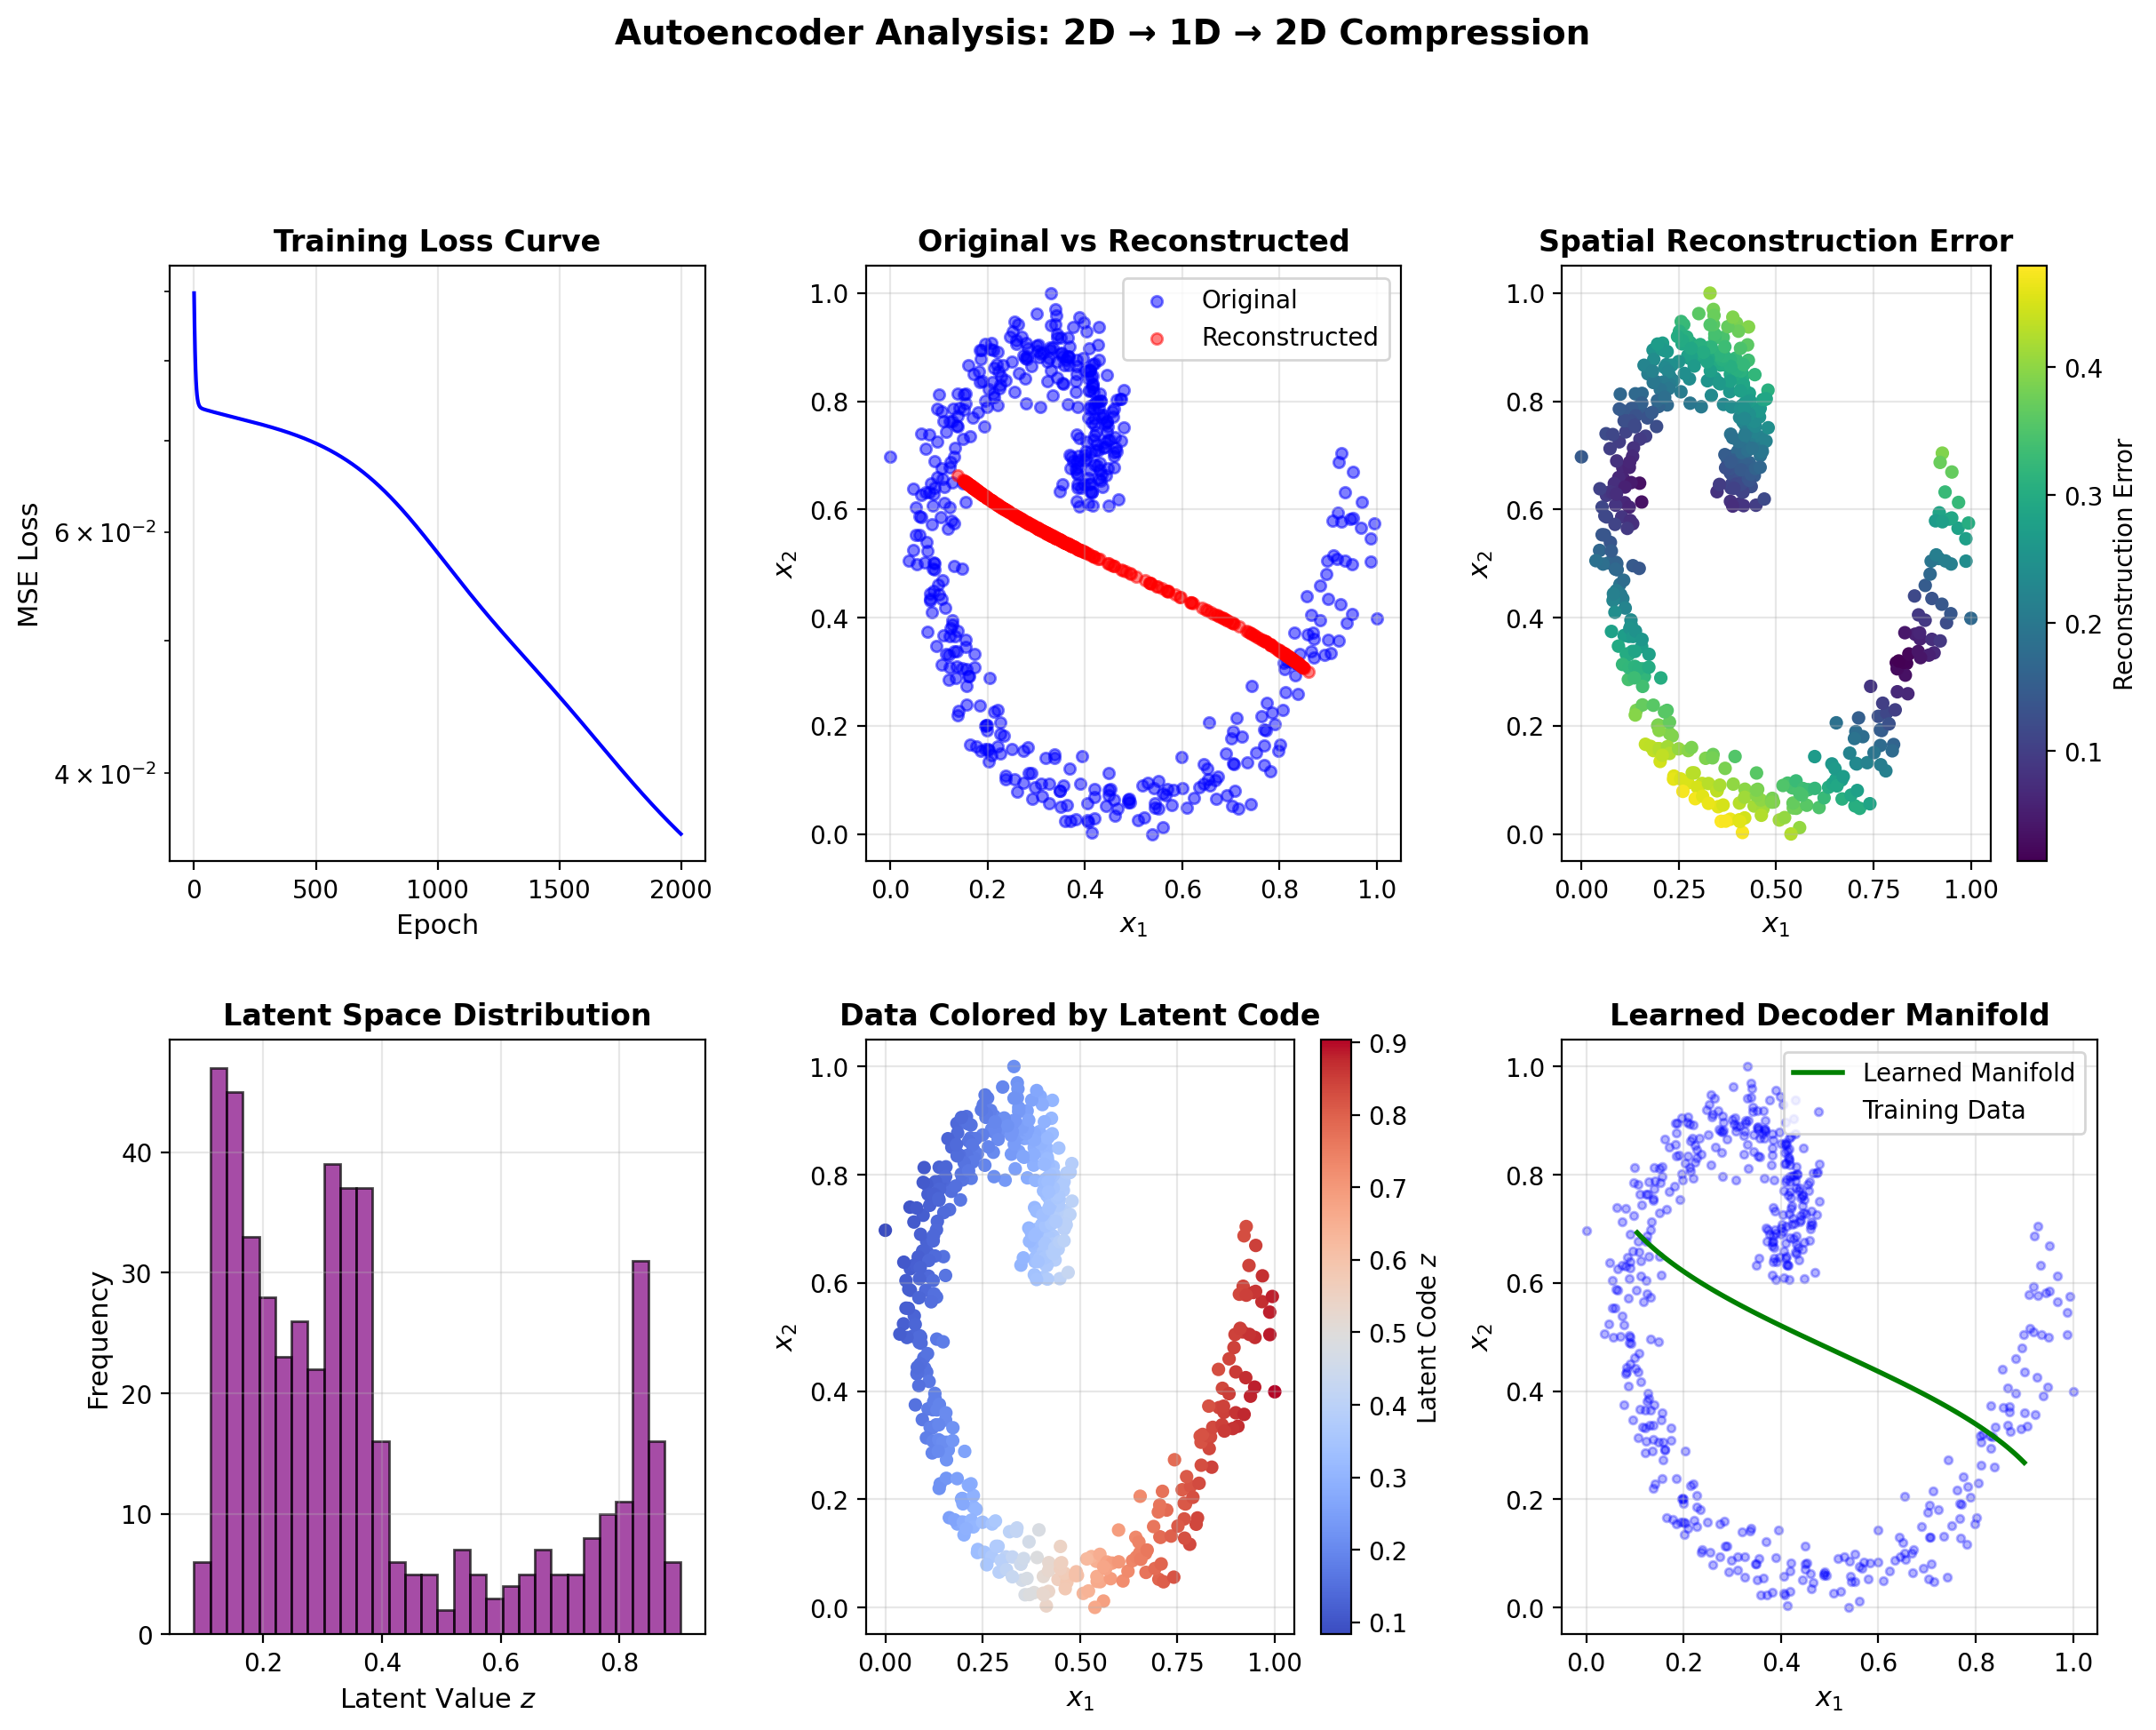


Plot saved to 'plot.png'


In [5]:
# Generate reconstructions
X_reconstructed = ae.forward(X_train)
latent_codes = ae.z

# Create comprehensive visualization
fig = plt.figure(figsize=(14, 10))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# Plot 1: Training Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(ae.loss_history, 'b-', linewidth=1.5)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('MSE Loss', fontsize=11)
ax1.set_title('Training Loss Curve', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Original vs Reconstructed Data
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(X_train[0, :], X_train[1, :], c='blue', alpha=0.5, s=20, label='Original')
ax2.scatter(X_reconstructed[0, :], X_reconstructed[1, :], c='red', alpha=0.5, s=20, label='Reconstructed')
ax2.set_xlabel('$x_1$', fontsize=11)
ax2.set_ylabel('$x_2$', fontsize=11)
ax2.set_title('Original vs Reconstructed', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Reconstruction Error
ax3 = fig.add_subplot(gs[0, 2])
errors = np.sqrt(np.sum((X_train - X_reconstructed)**2, axis=0))
scatter = ax3.scatter(X_train[0, :], X_train[1, :], c=errors, cmap='viridis', s=20)
plt.colorbar(scatter, ax=ax3, label='Reconstruction Error')
ax3.set_xlabel('$x_1$', fontsize=11)
ax3.set_ylabel('$x_2$', fontsize=11)
ax3.set_title('Spatial Reconstruction Error', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Latent Space Distribution
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(latent_codes.flatten(), bins=30, color='purple', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Latent Value $z$', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('Latent Space Distribution', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Plot 5: Data colored by latent code
ax5 = fig.add_subplot(gs[1, 1])
scatter2 = ax5.scatter(X_train[0, :], X_train[1, :], c=latent_codes.flatten(), cmap='coolwarm', s=20)
plt.colorbar(scatter2, ax=ax5, label='Latent Code $z$')
ax5.set_xlabel('$x_1$', fontsize=11)
ax5.set_ylabel('$x_2$', fontsize=11)
ax5.set_title('Data Colored by Latent Code', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Plot 6: Decoder manifold visualization
ax6 = fig.add_subplot(gs[1, 2])
z_range = np.linspace(0.01, 0.99, 100).reshape(1, -1)
decoded_manifold = ae.decode(z_range)
ax6.plot(decoded_manifold[0, :], decoded_manifold[1, :], 'g-', linewidth=2, label='Learned Manifold')
ax6.scatter(X_train[0, :], X_train[1, :], c='blue', alpha=0.3, s=10, label='Training Data')
ax6.set_xlabel('$x_1$', fontsize=11)
ax6.set_ylabel('$x_2$', fontsize=11)
ax6.set_title('Learned Decoder Manifold', fontsize=12, fontweight='bold')
ax6.legend(loc='upper right')
ax6.grid(True, alpha=0.3)

plt.suptitle('Autoencoder Analysis: 2D → 1D → 2D Compression', fontsize=14, fontweight='bold', y=1.02)

# Save the plot
plt.savefig('autoencoder_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nPlot saved to 'plot.png'")

## 7. Quantitative Analysis

In [6]:
# Compute metrics
mse = np.mean((X_train - X_reconstructed)**2)
mae = np.mean(np.abs(X_train - X_reconstructed))
max_error = np.max(np.sqrt(np.sum((X_train - X_reconstructed)**2, axis=0)))

# Compression ratio
compression_ratio = ae.input_dim / ae.latent_dim

print("Autoencoder Performance Metrics")
print("=" * 40)
print(f"Input Dimension:      {ae.input_dim}")
print(f"Latent Dimension:     {ae.latent_dim}")
print(f"Compression Ratio:    {compression_ratio:.1f}x")
print(f"")
print(f"Mean Squared Error:   {mse:.6f}")
print(f"Mean Absolute Error:  {mae:.6f}")
print(f"Max Point Error:      {max_error:.6f}")
print("=" * 40)

Autoencoder Performance Metrics
Input Dimension:      2
Latent Dimension:     1
Compression Ratio:    2.0x

Mean Squared Error:   0.036107
Mean Absolute Error:  0.152370
Max Point Error:      0.479090


## 8. Conclusions

This notebook demonstrated the implementation and analysis of a simple autoencoder:

1. **Architecture**: We built a 2D → 1D → 2D autoencoder that compresses data by 50%

2. **Training**: The model was trained using gradient descent with backpropagation, minimizing MSE loss

3. **Results**: 
   - The autoencoder successfully learned to compress and reconstruct the spiral data
   - The latent space captures the main variation in the data (position along the spiral)
   - The decoder learns a continuous manifold through the data

4. **Key Insights**:
   - Even a simple 1D bottleneck can capture meaningful structure in 2D data
   - The latent codes naturally order the data along its principal variation
   - Reconstruction error varies spatially, indicating areas of better/worse compression

### Extensions

This basic autoencoder can be extended to:
- **Variational Autoencoders (VAEs)**: Add probabilistic latent space
- **Denoising Autoencoders**: Add noise to inputs for robust features
- **Convolutional Autoencoders**: Use convolutions for image data
- **Deep Autoencoders**: Add multiple encoder/decoder layers